In [1]:
from pathlib import Path
from typing import Union, Callable, Any, Optional

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision

import util
import learning
import data_loaders

from importlib import reload

C:\Users\Danny\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
reload(learning)
reload(util)

<module 'util' (namespace)>

In [3]:
data_base_path = Path(r"F:\Coding\data-science\datasets\dog-breeds")

In [4]:
data_labels_df = pd.read_csv(data_base_path/"labels.csv")
label_names = sorted(data_labels_df['breed'].unique())
label_dict = {item: index for index, item in enumerate(label_names)}
for key in list(label_dict.keys())[:5]: print(f"{key}: {label_dict[key]}")

affenpinscher: 0
afghan_hound: 1
african_hunting_dog: 2
airedale: 3
american_staffordshire_terrier: 4


In [51]:
# https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html#sphx-glr-auto-examples-plot-scripted-tensor-transforms-py
# transforms =torch.nn.Sequential(
#     torchvision.transforms.RandomCrop(224),
#     torchvision.transforms.RandomHorizontalFlip(p=0.3)
# )

class DogVisionImageDataset(torch.utils.data.TensorDataset):
    """
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    labels_df: pd.DataFrame

    def __init__(
        self,
        img_dir: Path,
        labels_df: pd.DataFrame = None,
        transform: Union[Callable[[torch.Tensor], torch.Tensor], None] = None,
        target_transform: Union[Callable[[Union[torch.Tensor, Any]], torch.Tensor], None] = None,
        limit_data: Optional[int] = None,
    ):
        self.labels_df = labels_df
        
        if limit_data:
            self.labels_df = self.labels_df[:limit_data]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int):
        file_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]
        
        img_path = self.img_dir/f"{str(file_name)}.jpg"
        image = torchvision.io.read_image(str(img_path), torchvision.io.ImageReadMode.RGB).float() / 255
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = DogVisionImageDataset(
    img_dir=data_base_path/"train",
    labels_df=data_labels_df,
    transform=torchvision.transforms.Resize(size=(224, 224)),
    target_transform=torchvision.transforms.Lambda(lambda y: data_loaders.label_name_one_hot(y, label_dict)),
    # limit_data=1000
)
train_dataset, valid_dataset = data_loaders.split_datasets(dataset, validation_percent=0.1)
test_dataset = DogVisionImageDataset(
    img_dir=data_base_path/"test",
    transform=torchvision.transforms.Resize(size=(224, 224))
)


In [52]:
len(dataset)

10222

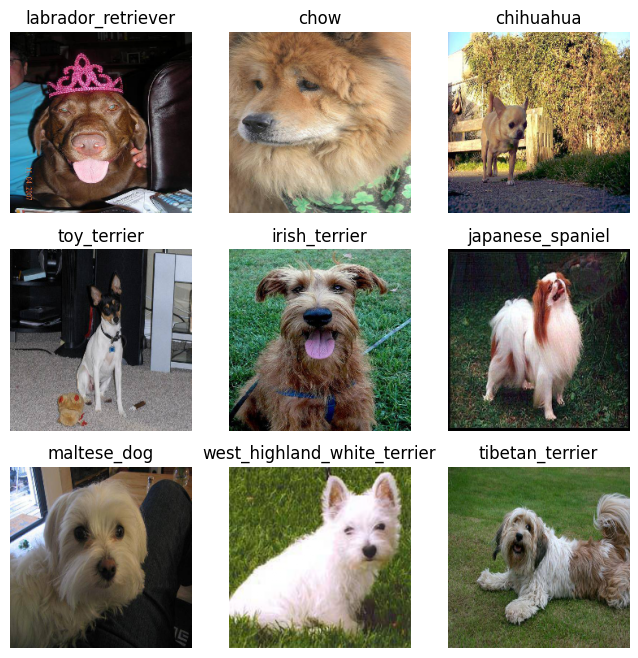

In [53]:
data_loaders.preview_data_sample(train_dataset, label_dict)

In [54]:
model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
# Freeze all pretrained parameters to avoid using them in training
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the head (the last layer, aka the final classification layer) with our own randomized weights
# and output the appropriate number of classes for our problem.
# The last layer was trained for the particular classification problem that the original model was intended for
# It is never any good for you (unless you are doing an identical problem)
# Match the in features with those of the original last layer, then specify new ones for the out for your problem
# Note that different models may have different names for the classification layer (see "image_nets fine-tuning conversation.md")
model.fc = torch.nn.Linear(model.fc.in_features, len(label_dict.items())).to("cuda")

epochs = 5
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        torch.utils.data.DataLoader(train_dataset, batch_size=32), 
        torch.utils.data.DataLoader(valid_dataset, batch_size=32),
        # TODO: figure out test dataset (no labels? Just pass none for label or don't pass at all?)
        torch.utils.data.DataLoader(valid_dataset, batch_size=32)
    ),
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    metric_function=learning.accuracy,
    optimizer=optimizer,
    scheduler=None,
    device="cuda"
    # device="cpu"
)

# TODOs
# Best way to normalize image sizes
# See how much unfreezing prior layers helps (aka fine tuning?)
learner.train_model(epochs=epochs)

⠇ Epochs     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━  80% -:--:-- 0:09:00 4 / 5 0.0244 loss
⠇ Validating ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━  97% 0:00:01 0:00:10 98.54 items/sec 0.0245 loss
                       Epochs                       
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Epoch ┃ Train Loss ┃ Valid Loss ┃ Metric ┃ Time  ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 1     │ 0.060193   │ 0.028601   │ 73.5%  │ 01:47 │
│ 2     │ 0.024062   │ 0.025452   │ 76.4%  │ 01:50 │
│ 3     │ 0.017855   │ 0.024663   │ 77.1%  │ 01:42 │
│ 4     │ 0.014284   │ 0.024382   │ 76.4%  │ 01:58 │
└───────┴────────────┴────────────┴────────┴───────┘

                       Epochs                       
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Epoch ┃ Train Loss ┃ Valid Loss ┃ Metric ┃ Time  ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 1     │ 0.060193   │ 0.028601   │ 73.5%  │ 01:47 │
│ 2     │ 0.024062   │ 0.025452   │ 76.4%  │ 01:50 │
│ 3     │ 0.017855   │ 0.024663   │ 77.1%  │ 01:42 │
│ 4     │ 0.014284   │ 0.024382   │ 76.4%  │ 01:58 │
│ 5     │ 0.011847   │ 0.024276   │ 76.5%  │ 01:40 │
└───────┴────────────┴────────────┴────────┴───────┘

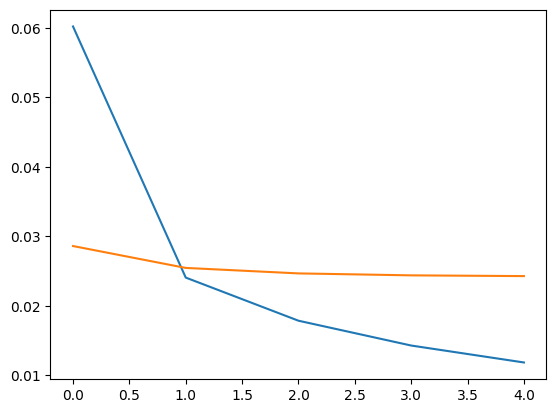

In [58]:
# TODO: function in learner to check test dataset (on 1 batch first)
# update function in dataloaders to display a grid of images with their preds and actuals
learner.plot_epoch_data()

In [65]:
reload(data_loaders)

<module 'data_loaders' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\data_loaders.py'>

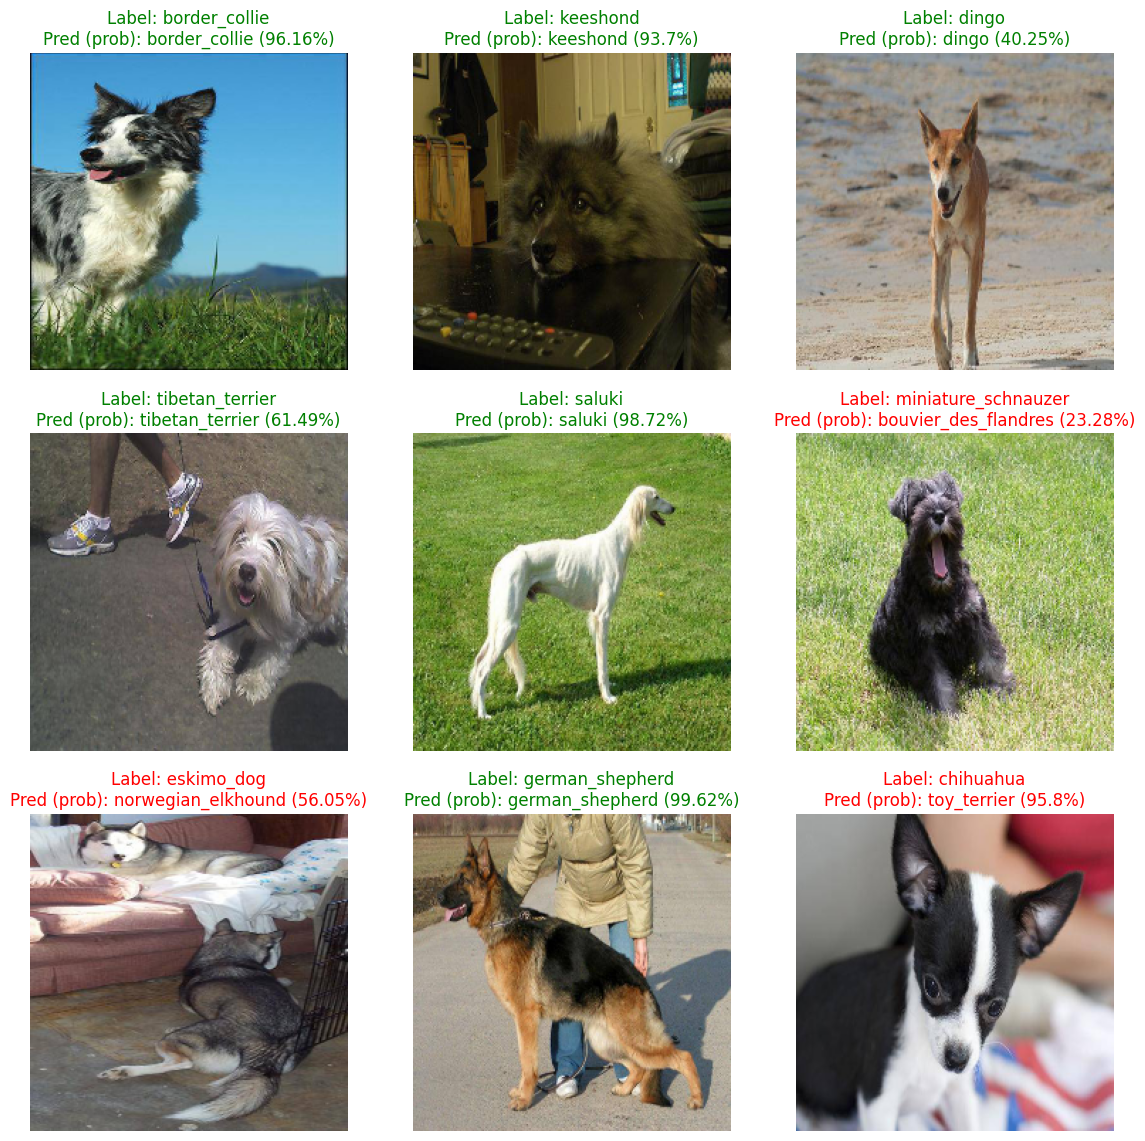

In [66]:
data_loaders.preview_tested_data_sample(valid_dataset, model, label_dict, "cuda")